In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from arima_models import (
    train_arima,
    train_arima_viz,
    best_arima_model,
    plot_correlogram,
    log_diff_prep,
)

## Get and massage portfolio data

In [2]:
ticker_histories_filename = os.path.join("input", "ticker_histories.csv")
ticker_histories_df = pd.read_csv(ticker_histories_filename)
ticker_histories_df["datetime"] = pd.to_datetime(
    ticker_histories_df["timestamp"], unit="ms"
).dt.tz_localize(None)
ticker_histories_df.set_index("datetime", inplace=True)
ticker_histories_df.drop("timestamp", axis=1, inplace=True)
ticker_histories_df.sort_index(inplace=True)
ticker_histories_df

,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2020-04-01 04:00:00,AMZN,96.6485,97.2480,94.6500,95.3850,82437500.0,95.8985,141417
2020-04-01 04:00:00,MSFT,153.0000,157.7500,150.8200,152.1100,57969926.0,153.7717,531817
2020-04-01 04:00:00,AAPL,61.6250,62.1800,59.7825,60.2275,176046552.0,60.9782,460605
2020-04-01 04:00:00,GOOG,56.1000,56.4845,54.8725,55.2810,46883460.0,55.6376,71423
2020-04-01 04:00:00,NVDA,6.3913,6.5383,6.0320,6.0768,656913120.0,6.2836,185913
...,...,...,...,...,...,...,...,...
2025-03-13 04:00:00,AAPL,215.9500,216.8394,208.4200,209.6800,59752532.0,212.0980,768619
2025-03-13 04:00:00,GOOG,167.9800,168.1200,164.0700,164.7300,14841144.0,165.4467,253905
2025-03-13 04:00:00,AMZN,198.1650,198.8799,191.8200,193.8900,39427497.0,194.3506,588340


In [3]:
adj_close_df = ticker_histories_df.reset_index().pivot(
    index="datetime", columns="ticker", values="close"
)
adj_close_df.index = pd.DatetimeIndex(adj_close_df.index)
adj_close_df.index = pd.DatetimeIndex(
    [dt.replace(hour=17, minute=0, second=0) for dt in adj_close_df.index]
)
adj_close_df

ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
2020-04-01 17:00:00,60.2275,95.3850,55.2810,152.11,6.0768,32.1040
2020-04-02 17:00:00,61.2325,95.9415,56.0420,155.26,6.3868,30.2980
2020-04-03 17:00:00,60.3525,95.3295,54.8940,153.83,6.0977,32.0007
2020-04-06 17:00:00,65.6175,99.8795,59.3460,165.27,6.7100,34.4160
2020-04-07 17:00:00,64.8575,100.5800,59.3255,163.49,6.4758,36.3633
...,...,...,...,...,...,...
2025-03-07 17:00:00,239.0700,199.2500,175.7500,393.31,112.6900,262.6700
2025-03-10 17:00:00,227.4800,194.5400,167.8100,380.16,106.9800,222.1500
2025-03-11 17:00:00,220.8400,196.5900,165.9800,380.45,108.7600,230.5800
2025-03-12 17:00:00,216.9800,198.8900,169.0000,383.27,115.7400,248.0900


In [4]:
ticker_decomps = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close = adj_close.asfreq("B", method="ffill")
    components = tsa.seasonal_decompose(adj_close, model="additive")
    adj_close_decomp_df = (
        adj_close.to_frame("original")
        .assign(trend=components.trend)
        .assign(seasonal=components.seasonal)
        .assign(residual=components.resid)
    )
    ticker_decomps[ticker] = adj_close_decomp_df

## Plot the trends for each ticker

In [5]:
def plot_decomp(df, title):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title("Original")
    axs[1].plot(df["trend"], color="orange")
    axs[1].set_title("Trend")
    axs[2].plot(df["seasonal"], color="green")
    axs[2].set_title("Seasonal")
    axs[3].plot(df["residual"], color="red")
    axs[3].set_title("Residual")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

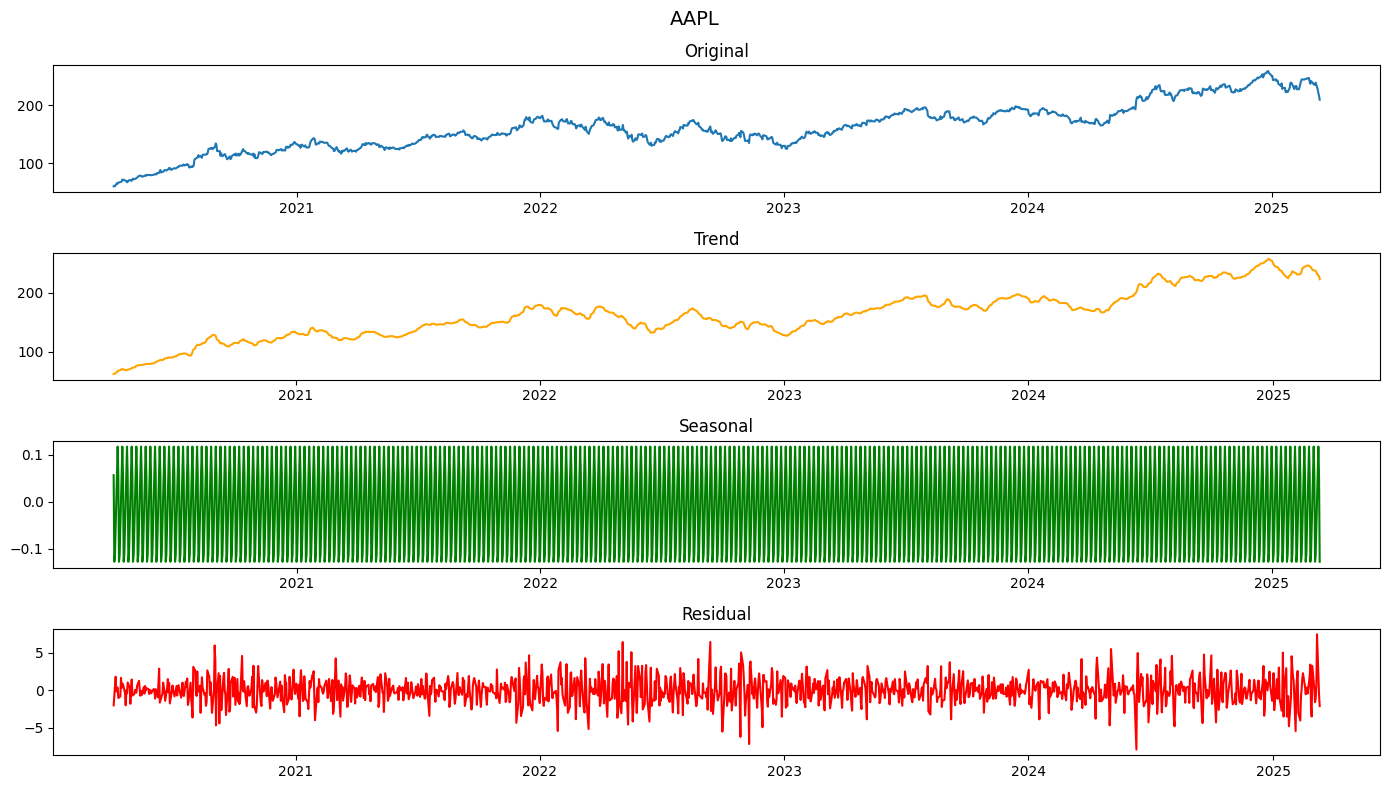

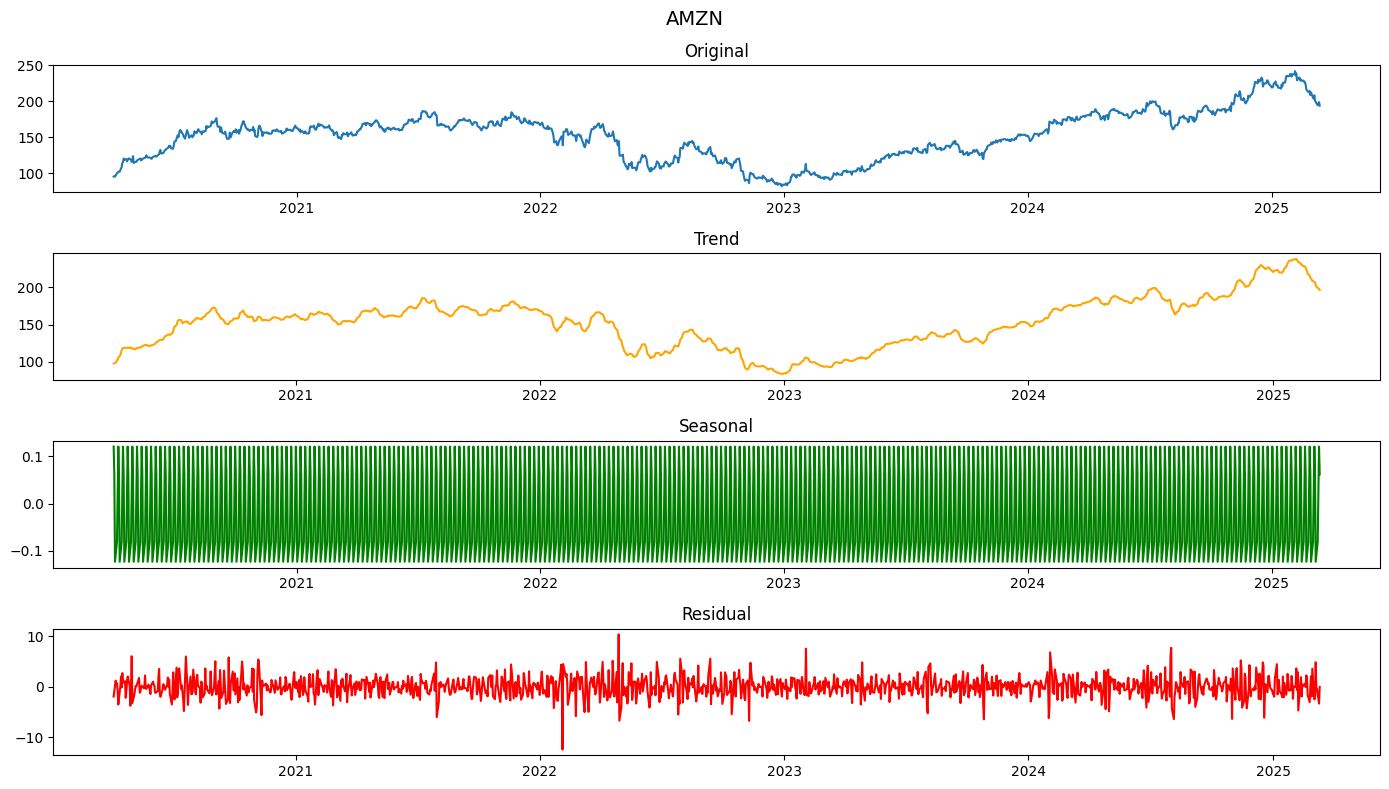

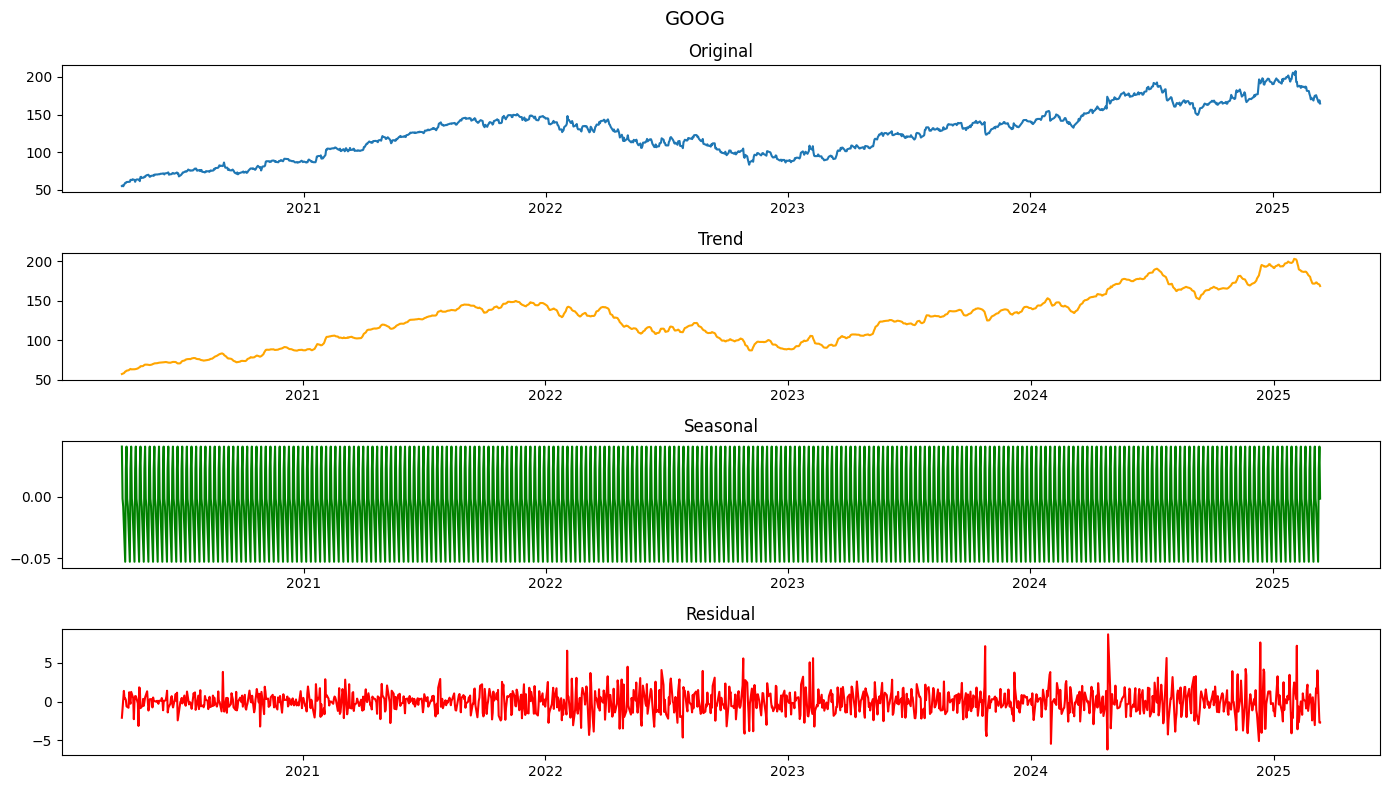

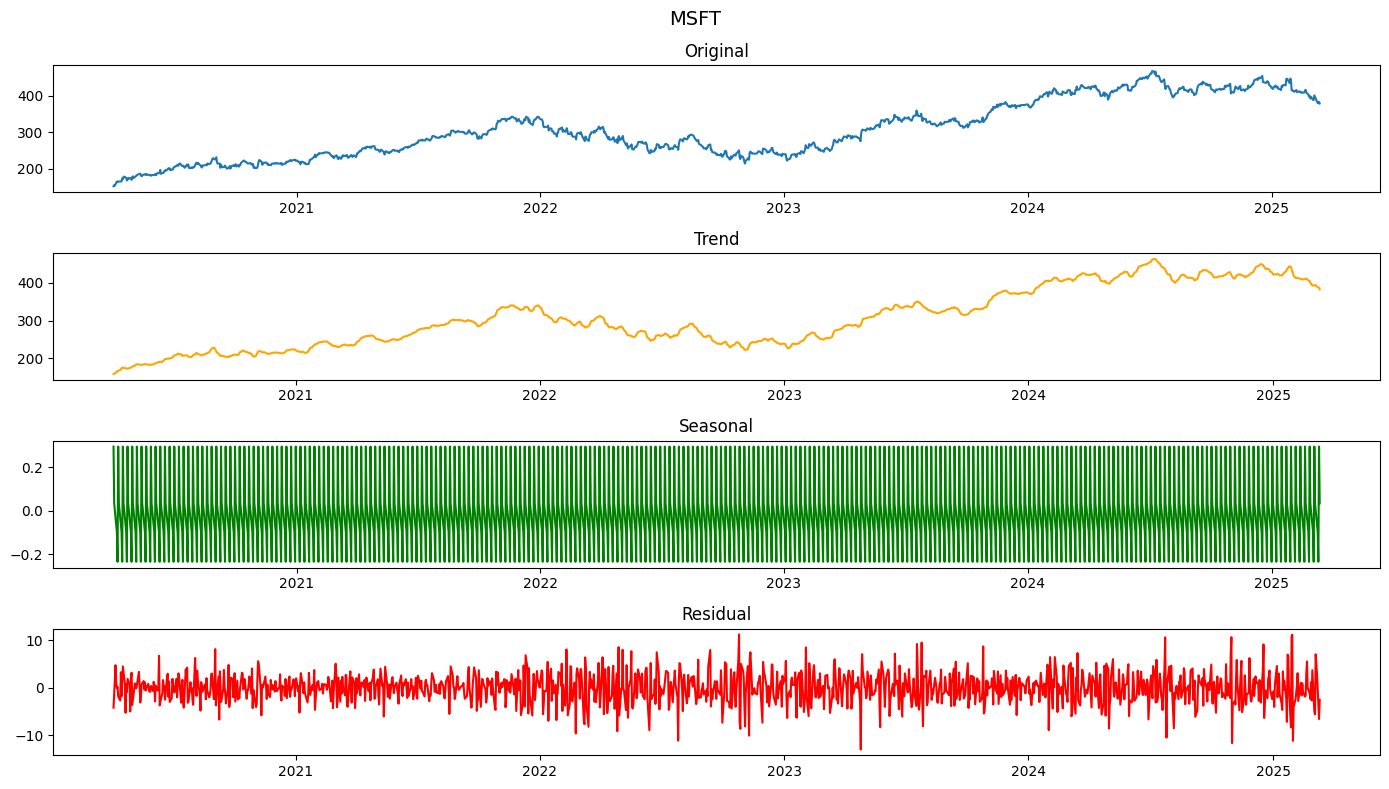

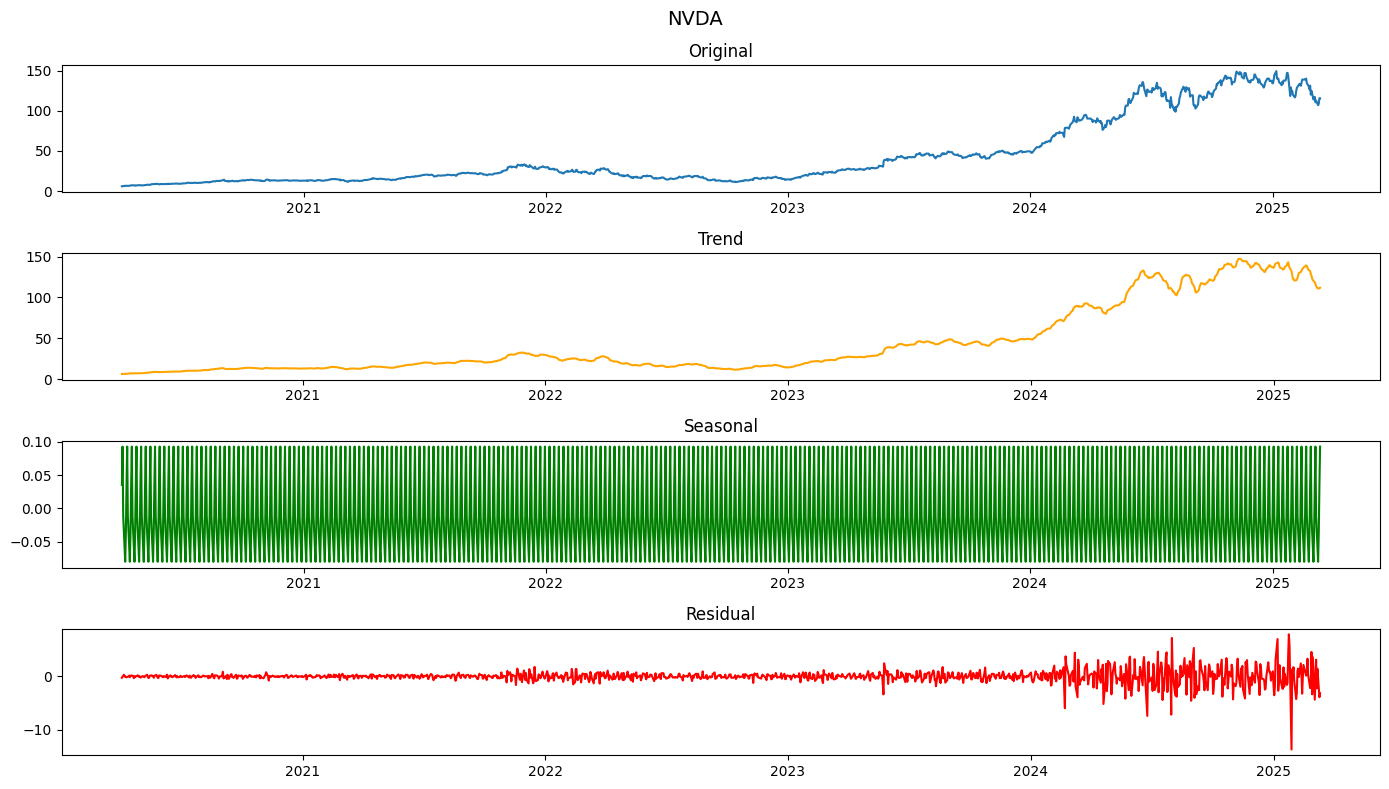

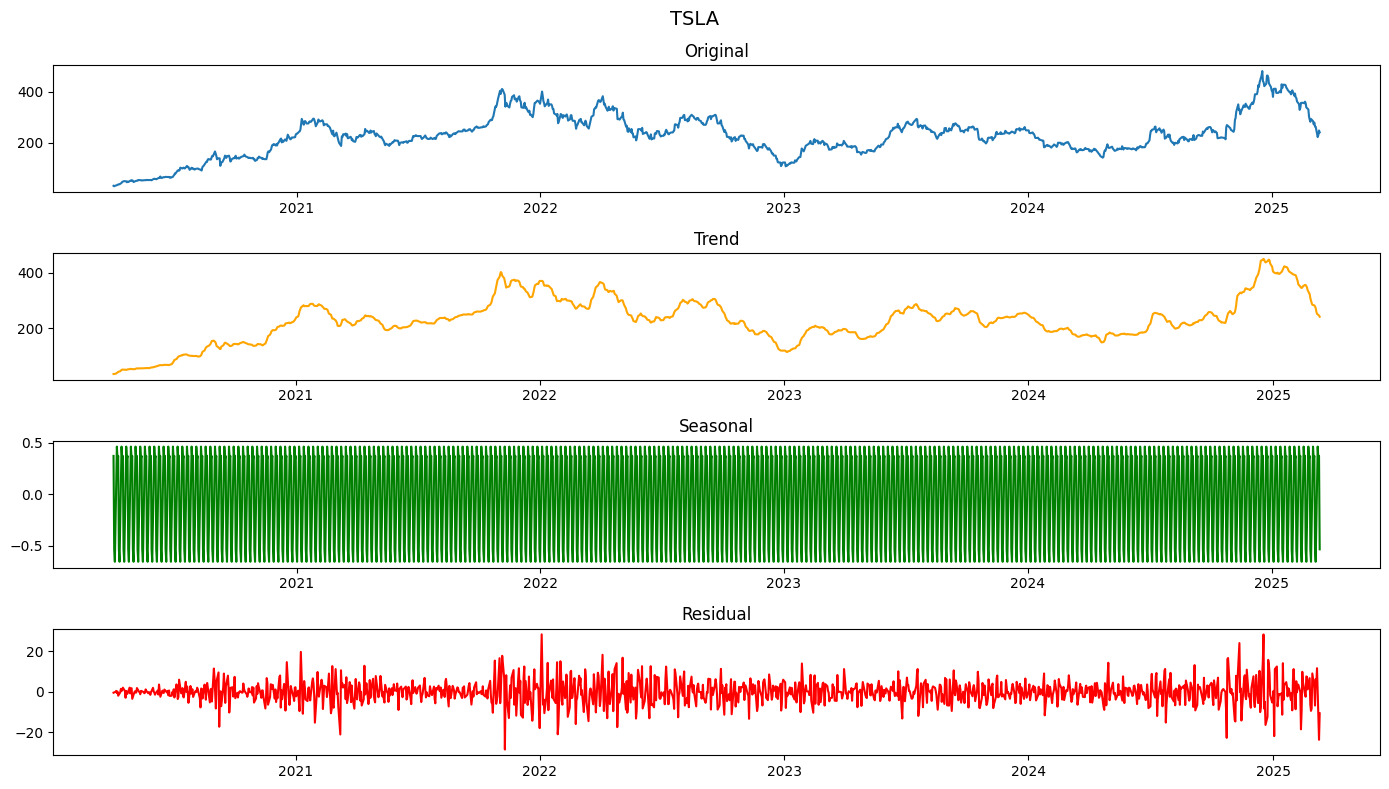

In [6]:
for ticker, decomp in ticker_decomps.items():
    plot_decomp(decomp, ticker)

## Differencing and log transforms

In [7]:
ticker_diffs = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close_log = np.log(adj_close)
    adj_close_log_diff_1 = adj_close_log.diff()
    diff_df = (
        adj_close.to_frame("original")
        .assign(log=adj_close_log)
        .assign(log_diff_1=adj_close_log_diff_1)
    )
    ticker_diffs[ticker] = diff_df

In [8]:
def plot_log_diffs(df, title):
    original_adf_p = adfuller(df["original"].dropna())[1]
    log_adf_p = adfuller(df["log"].dropna())[1]
    log_diff_1_adf_p = adfuller(df["log_diff_1"].dropna())[1]
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title(f"original, p={original_adf_p:.4f}")
    axs[1].plot(df["log"], color="orange")
    axs[1].set_ylabel("log")
    axs[1].set_title(f"log, p={log_adf_p:.4f}")
    axs[2].plot(df["log_diff_1"], color="green")
    axs[2].set_ylabel("log, diff")
    axs[2].set_title(f"log diff, p={log_diff_1_adf_p:.4f}")
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

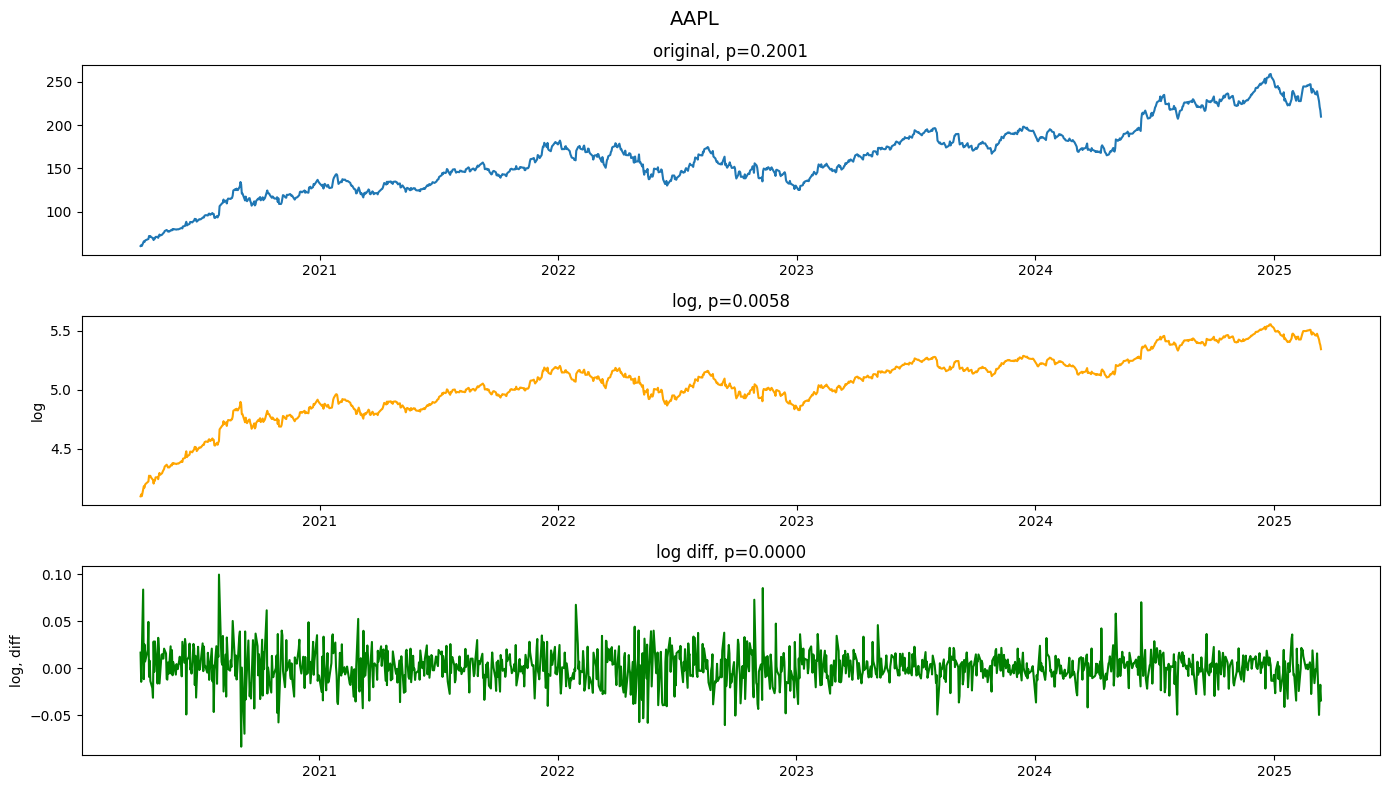

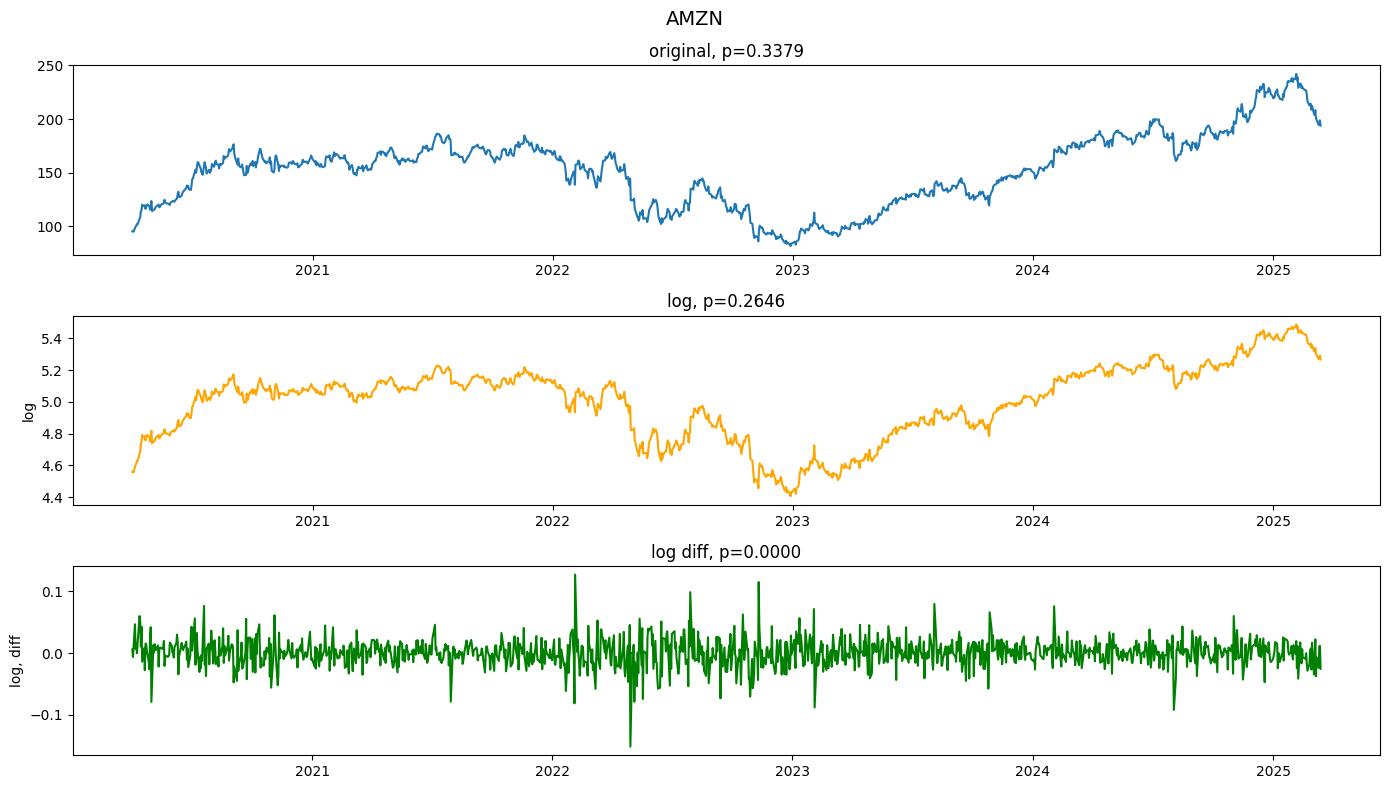

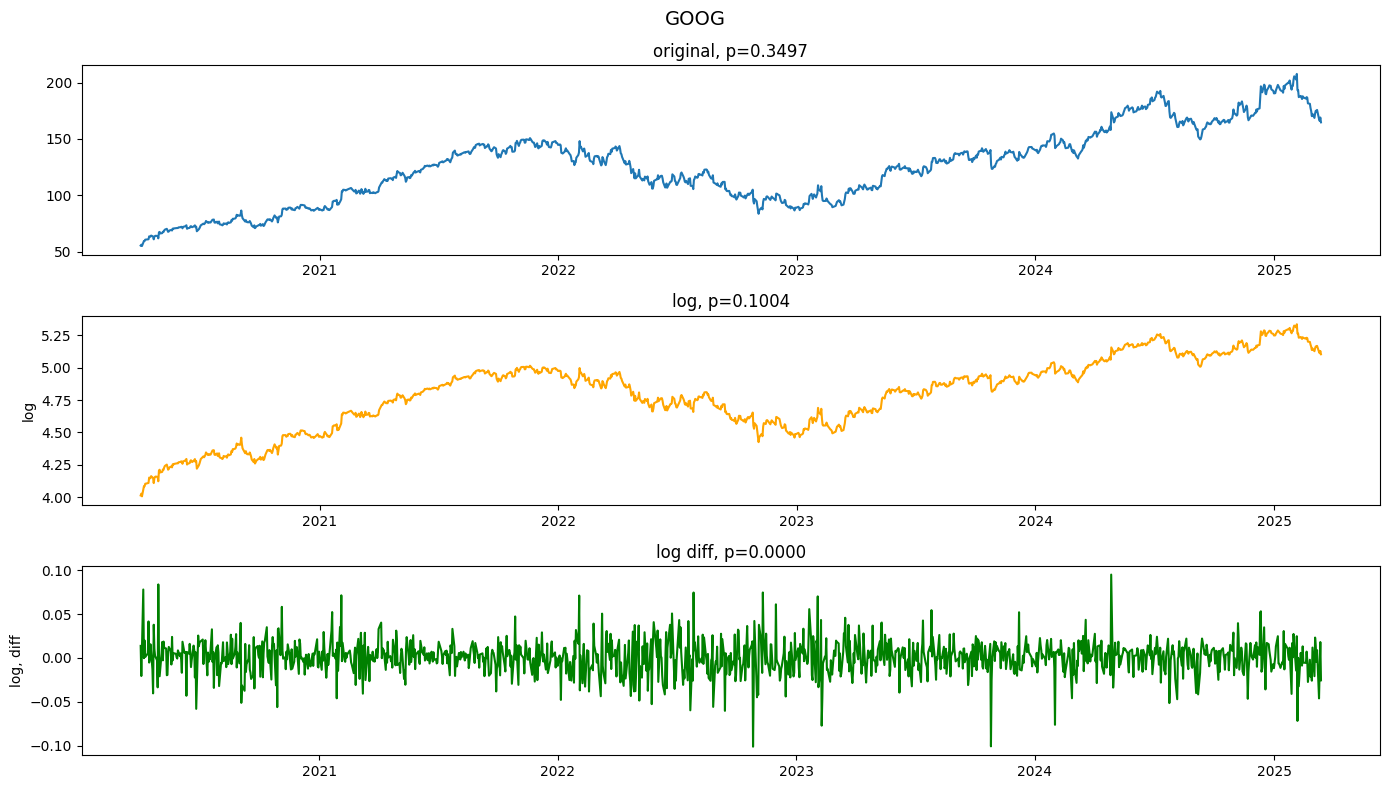

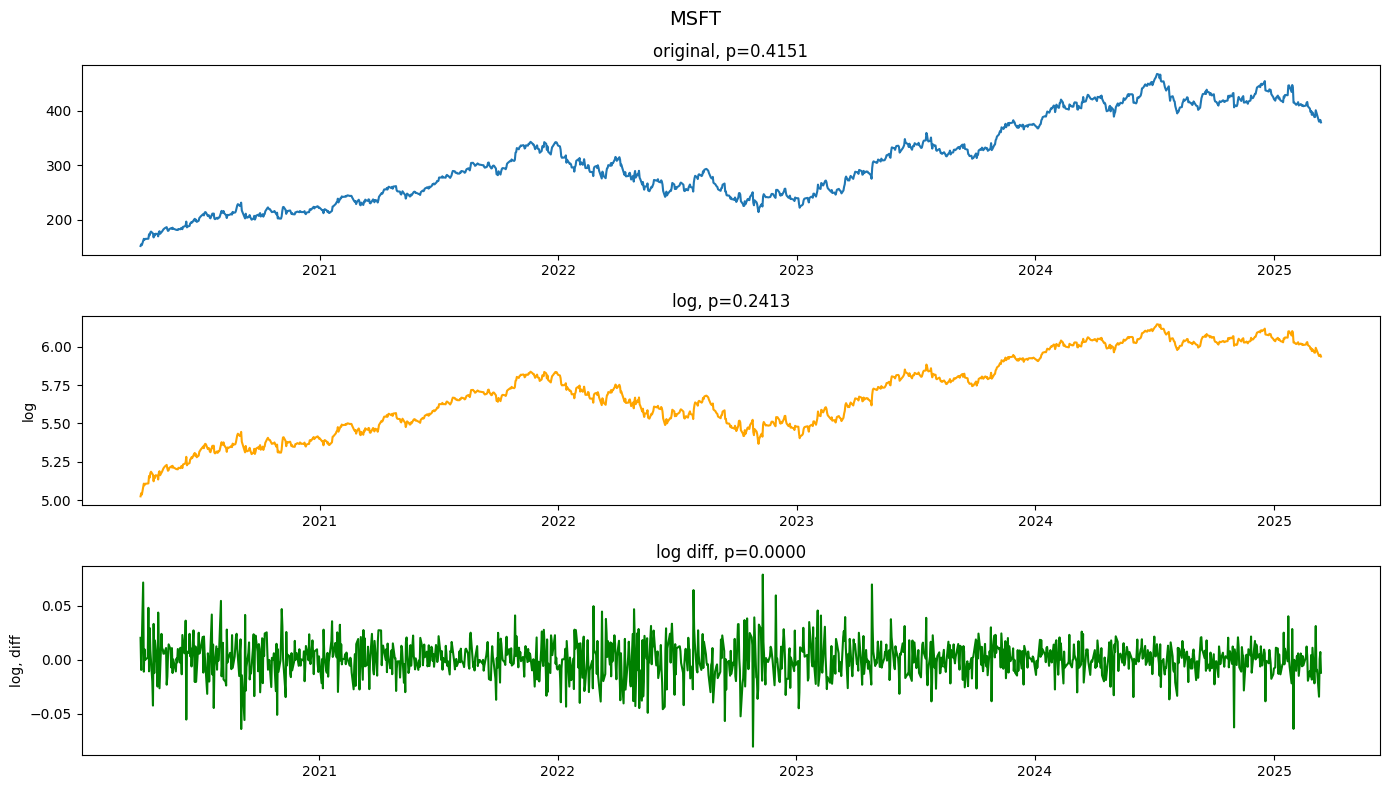

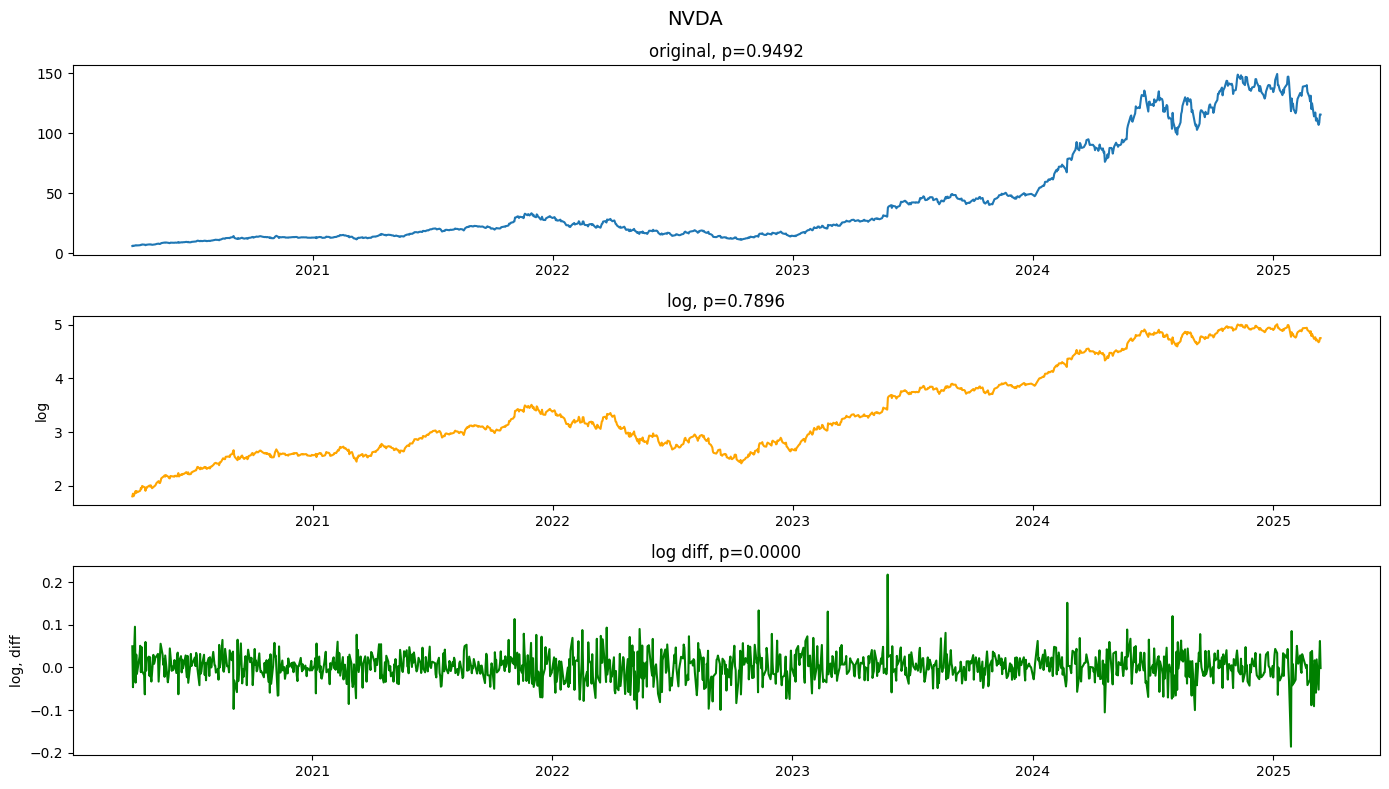

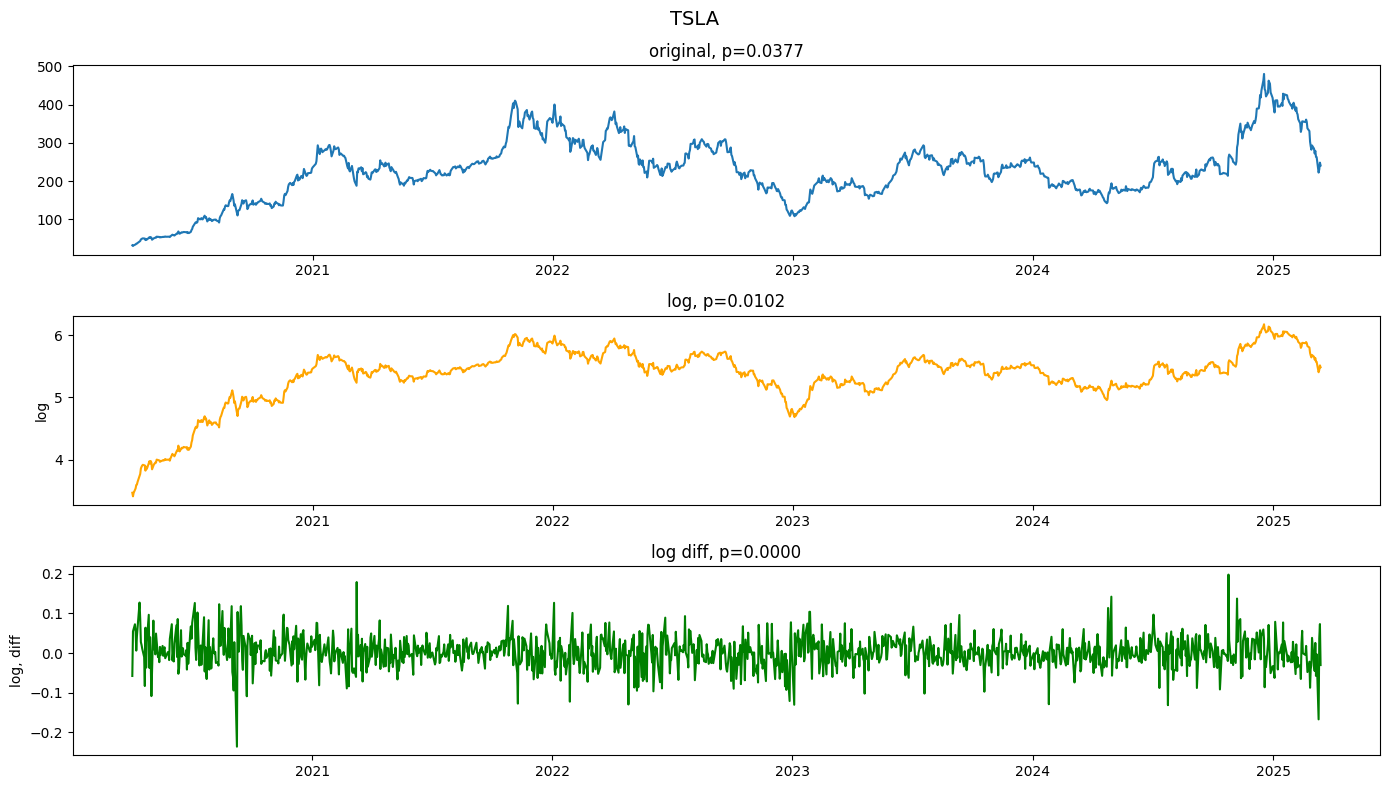

In [9]:
for ticker, d in ticker_diffs.items():
    plot_log_diffs(d, ticker)

## Fit ARIMA models

### First AAPL

Try the functions on AAPL.

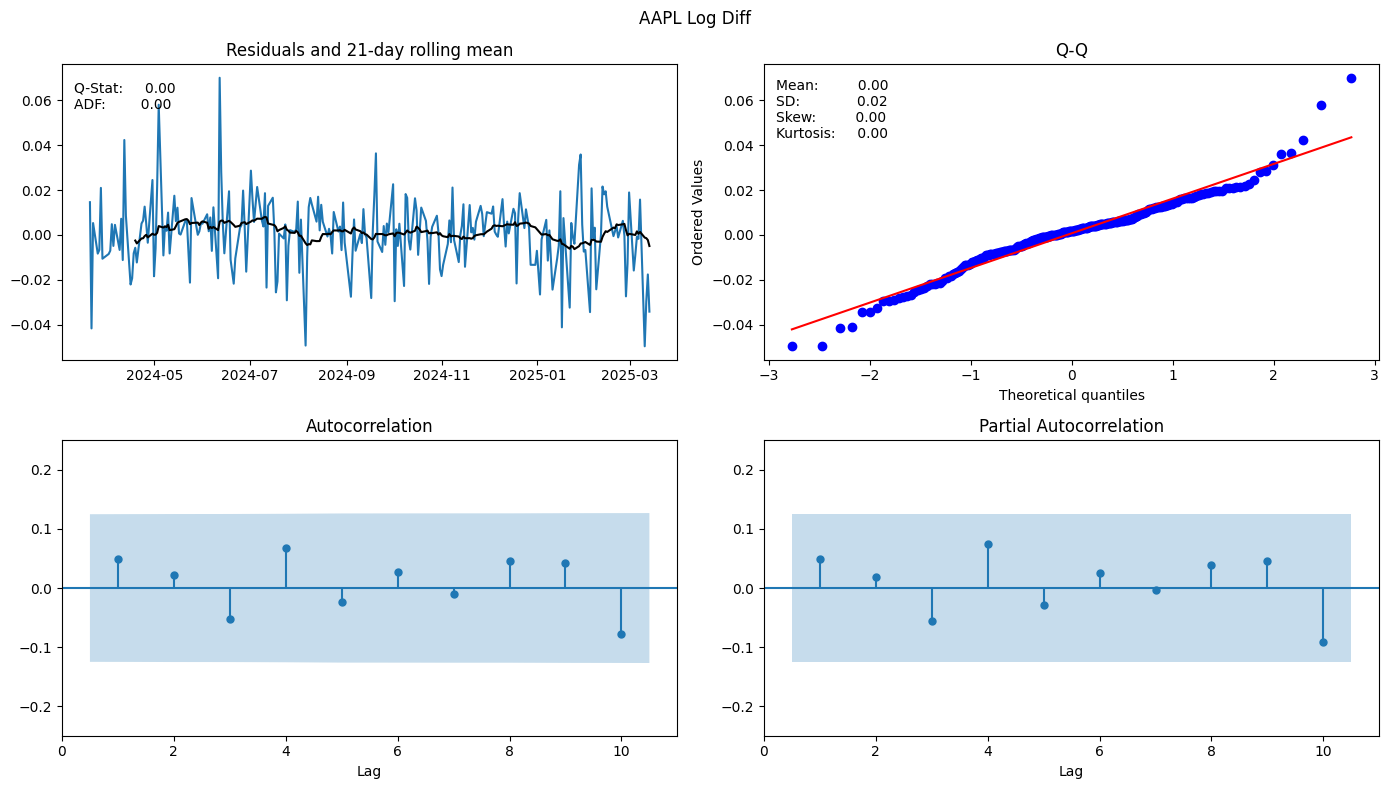

In [10]:
aapl = adj_close_df["AAPL"]
aapl_selection = aapl.loc[aapl.index > pd.Timestamp("2024-03-19")]
# aapl_log_diff = np.log(aapl_selection).diff()
aapl_log_diff = log_diff_prep(aapl_selection)
plot_correlogram(aapl_log_diff, nlags=10, title="AAPL Log Diff", acf_plot_ymax=0.25)

In [11]:
aapl_train_result = train_arima(aapl_log_diff, d=0, train_len=90)
aapl_train_result

Processing:   0%|          | 0/24 [00:00<?, ?task/s]/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing:   4%|▍         | 1/24 [00:04<01:33,  4.09s/task]/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.

,,rmse,mean_aic,mean_bic,n_convergence_errors,n_stationarity_errors
p,q,,,,,
1,0,0.014908,-503.479750,-495.980321,0,0
0,1,0.014911,-503.471913,-495.972484,0,0
2,0,0.015015,-501.999021,-491.999782,0,0
3,0,0.015090,-501.561146,-489.062098,0,0
1,1,0.014992,-501.647592,-491.648353,0,0
0,2,0.015016,-501.900785,-491.901546,0,0
3,1,0.015188,-500.453151,-485.454293,0,0
1,2,0.015043,-500.511561,-488.012513,0,0
0,3,0.015245,-502.270423,-489.771375,0,0


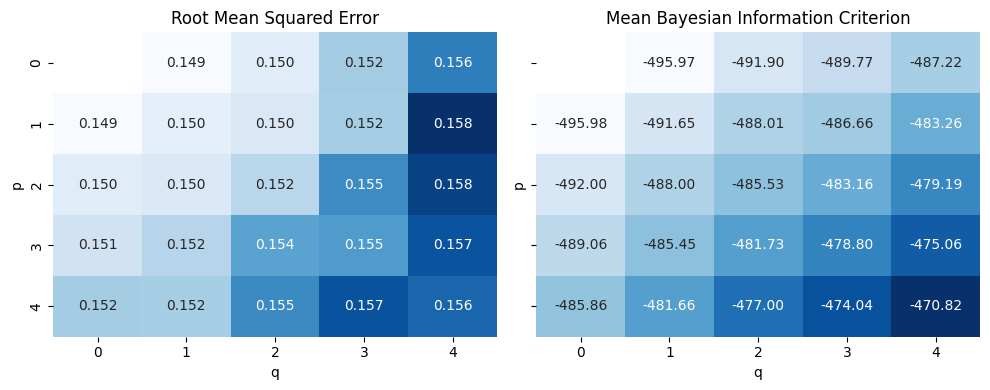

In [12]:
train_arima_viz(aapl_train_result)

In [13]:
aapl_best = best_arima_model(aapl_log_diff, aapl_train_result)
print(aapl_best.summary())

1 0
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  247
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 673.659
Date:                Wed, 19 Mar 2025   AIC                          -1341.318
Time:                        19:08:58   BIC                          -1330.789
Sample:                             0   HQIC                         -1337.079
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.671      0.502      -0.001       0.003
ar.L1          0.0502      0.058      0.861      0.389      -0.064       0.164
sigma2         0.0002   1.51e-05     16.231     

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


247


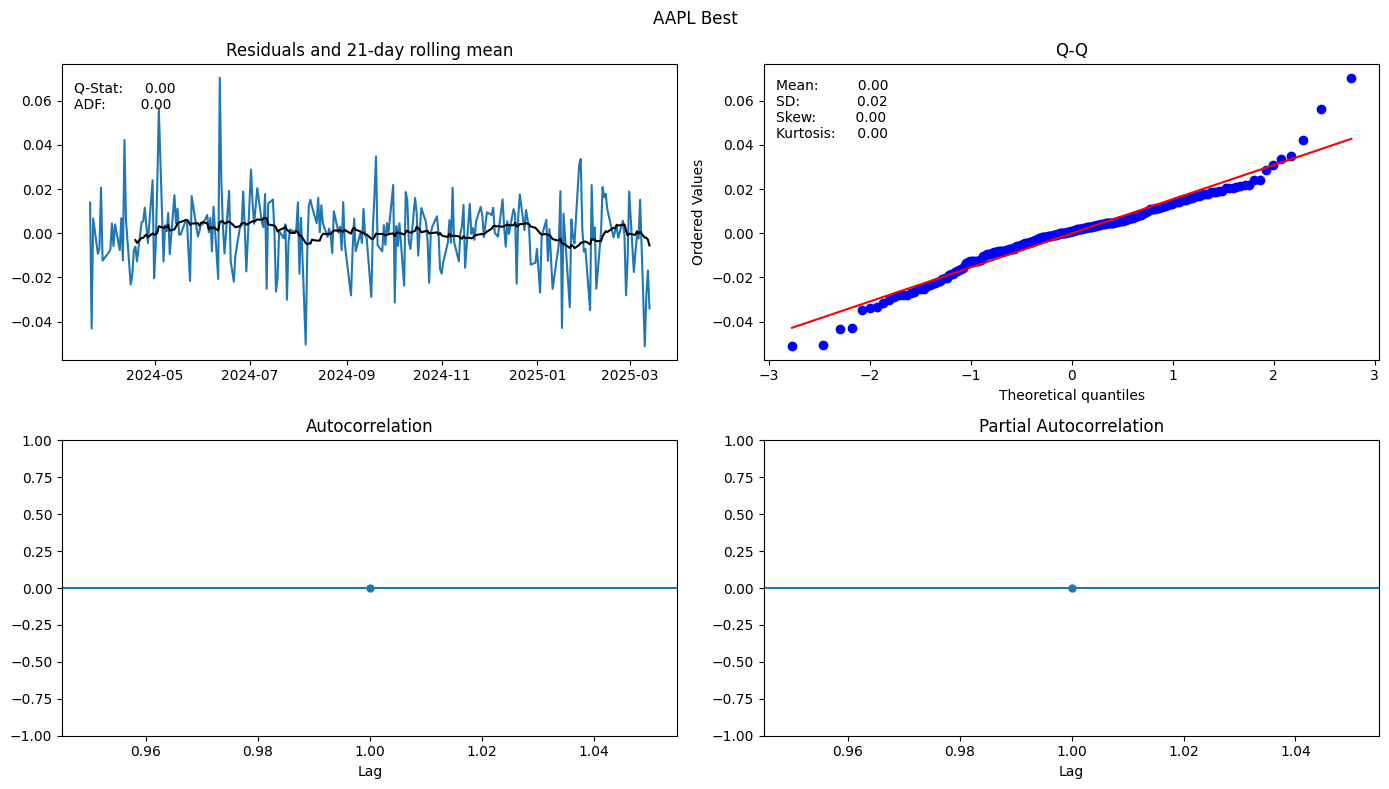

In [14]:
print(len(aapl_best.resid))
plot_correlogram(aapl_best.resid, nlags=1, title="AAPL Best", acf_plot_ymax=1.0)

## Final foreacast

The last adjusted close price the model was trained on was 3/13/2025, so predict the adjusted close price of AAPL on 3/14/2025 (which was ~$213).

First get a 1-step ahead forecast from the log returns model.

In [15]:
forecast = aapl_best.forecast(steps=1)
forecast.iloc[0]

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


np.float64(-0.0010462116603374666)

Then use the prediction to predict the next close price from the end of the raw adjusted close values.

In [16]:
aapl.iloc[-1] * np.exp(forecast.iloc[0])

np.float64(209.46074505260069)

That is -4 dollars from the actual price!